# Finite-state grammar algorithms

This notebook covers building weighted finite-state transducer (WFST) grammars using the [Pynini](http://pynini.opengrm.org) library (Gorman 2016).

In [1]:
import pynini

## String compilation

### Acceptors

The `acceptor` function compiles an FST into a string. By default (`token_type="byte"`) it interprets the string as a sequence of bytes, assigning one _byte_ per arc. If `token_type=utf8`, it interprets the string as a sequence of UTF-8-encoded Unicode codepoints and assigns one _codepoint_ per arc. One can also pass a [symbol table](PyniniSymbolTableDoc) to use to parse the input into arcs.

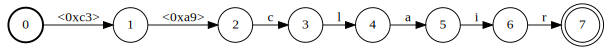

In [2]:
pynini.acceptor("éclair")  # Byte tokens.

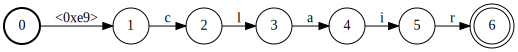

In [3]:
pynini.acceptor("éclair", token_type="utf8")

One can also specify a final weight with the `weight` keyword argument, select a non-standard arc type with `arc_type`.

`byte` and `utf8` modes follow special conventions for parsing (unescaped) ASCII
square bracket characters `[` and `]`. When a string is enclosed by a set of
(unescaped) square brackets, we refer to it as a _bracketed span_. The
delimiting brackets are subsequentely ignored and the bracketed span is
interpreted as follows:

1. If the bracketed span is empty, an error results.
2. If the bracketed span contains one or more space characters, each space-delimited token is treated as a "generated" symbol and added to the symbol table attached to the resulting FSA (at a suitably high index so as to avoid any collisions with BMP codepoints).
3. Otherwise, the bracketed span is run through `stroll`. If `strtoll` can parse the entire span as a (octal, hexidecimal, or decimal) integer, the span is labeled using that integer. Otherwise, the span is treated as a "generated" symbol and added to the symbol table attached to the resulting FSA (at a suitably high index so as to avoid any collisons with BMP codepoints). To "escape" a bracket literal, use a backslash.

The following pairs of input strings and corresponding labels illustrate how
brackets are parsed in `byte` and `utf8` mode:

   *   `[0146][0x6f][111]`: {102, 111, 111}
   *   `[foo bar baz]`: {1048577, 1048578, 1048579}
   *   `foo[foo foo]`: {102, 111, 111, 1048577, 1048577}
   *   `foo[foo][foo]`: {102, 111, 111, 1048577, 1048577}
   *   `foo\[bar\]`: {102, 111, 111, 91, 98, 97, 114, 93}

### Transducers

The `transducer` function produces a "cross-product" FST from two strings. Epsilon is used to pad when one string is longer than the other. The user can specify separate `input_token_type` and `output_token_type`, as well as arc type and a final weight.

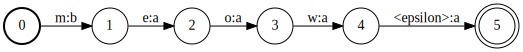

In [4]:
pynini.transducer("meow", "baaaa")

The `transducer` function can also be used to build the cross-product from two precompiled FSTs; the output tape of the left-hand-side FST and the input tape of the right-hand-side FST are discarded and the two are concatenated.

### String maps

String maps are the union of several acceptors and/or transducers built from a list of strings provided as one to three columns of data:

1. One column: acceptor
2. Two columns: transducer
3. Three columns: weighted transducer

They can be built from Python lists and tuples using `string_map` or from a TSV file using `string_file`.

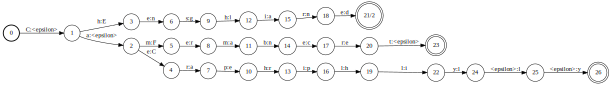

In [5]:
pynini.string_map((("Caerphilly",),                # Acceptor.
                   ("Camembert", "France"),        # Transducer.
                   ("Cheshire", "England", "2")))  # Weighted transducer.

## API conventions

* Constructive algorithms are implemented as module-level functions, and return `pynini.Fst` objects.
* Destructive algorithms are methods of `pynini.Fst`; but these methods also return `self`, so they can be chained (see examples below).
* For each destructive algorithm, there is also a function alias: this simply makes a copy of the input FST, applies the destructive method, and returns it.
* The operators `@`, `|`, `+`, and `-` are overloaded for FSTs and perform the corresponding rational operations.
* When a string is passed where an FST is expected, it is implicitly converted to an FST using `acceptor`'s defaults.
* Algorithms signal failures by raising custom exceptions. However, an empty FST (such as produced by composition failure) is itself not an error.

## Rational operations

### Concatenation

The `concat` function (or the operator `+`) produces an FST whos paths are the concatenation of those FSTs. The Thompson algorithm adds an epsilon arc from final states in the left-hand-side FST to the start state of the right-hand-side FSTs.

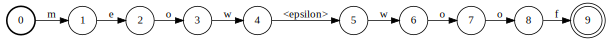

In [6]:
cat = pynini.acceptor("meow")
dog = pynini.acceptor("woof")
pynini.concat(cat, dog)  # Or: cat + dog

### Closure

The `closure` method produces the concatenative closure of an FST. The following shows how this syntax corresponds to PCRE regular expressions:


    Regexp:           This method:            Copy shortcuts:

    /x?/              x.closure(0, 1)         x.ques
    /x*/              x.closure()             x.star
    /x+/              x.closure(1)            x.plus
    /x{N}/            x.closure(N, N)
    /x{M,N}/          x.closure(M, N)
    /x{N,}/           x.closure(N)
    /x{,N}/           x.closure(0, N)

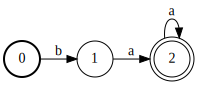

In [7]:
sheep = pynini.acceptor("b") + pynini.acceptor("a").closure(1)
sheep.optimize()  # Makes this a bit easier to read; see below.

### Inversion

The relations between sets of strings modeled by finite-state transducers are trivially invertible: we just have to swap input and output labels. The `invert` method performs this operation.

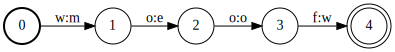

In [8]:
cat2dog = pynini.transducer(cat, dog)
dog2cat = pynini.invert(cat2dog)
dog2cat

### Projection

Projection takes a transducer and converts it to an acceptor. There are two variants:
    
* input projection (denoted by the prefix operator $\pi_i$) creates an acceptor over the _domain_ (i.e., the input language) of the transducer
* output projection (denoted by the prefix operator $\pi_o$) creates an acceptor over the _range_ (i.e., the output language) of the transducer

Like inversion, the algorithm is trivial: we simply copy input labels to output labels, or vis versa.

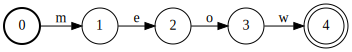

In [9]:
cat = pynini.project(cat2dog, project_output=False)
cat

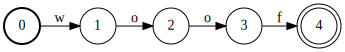

In [10]:
dog = pynini.project(cat2dog, project_output=True)
dog

### Union

The `union` method (or the operator `|`) encodes the union of two or more FSTs. The Thompson algorithm adds an epsilon arc from the start state of the left-hand-side FST to the start state of the right-hand-side FST(s).

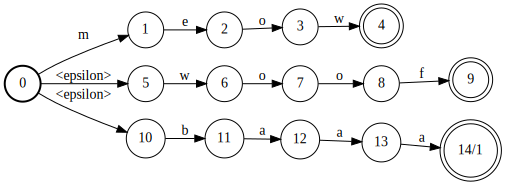

In [11]:
sheep = pynini.acceptor("baaa", weight=1)
animals = pynini.union(cat, dog, sheep)  # Or: cat | dog | sheep
animals

### Reversal

The `reverse` function produces an FST whose paths are the reverse of the input FST. Many FST algorithms are more efficient when applied in reverse order. The Thompson algorithm adds an epsilon arc for each final state.

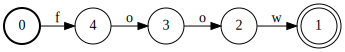

In [12]:
pynini.reverse(dog).rmepsilon()

### Composition

The `compose` function (or the `@` operator) implements composition, arguably the key algorithm for WFSTs. The semantics of composition depends on the inputs:

* The composition of two FSAs is their intersection of their languages (this can also be done with the `intersect` function, which just checks that both arguments are FSAs before composing them)
* The composition of an FSA and an FST intersects the FSA's language with the domain of the FST; when followed by output-projection, it is equivalent to function application
* The composition of an FST and an FSA intersects the FSA's language with the range of the FST.
* The composition of two FSTs is equivalent to chaining their relation.

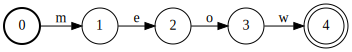

In [13]:
# Intersection.
pynini.compose(animals, cat)   # Or: animals @ cat

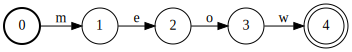

In [14]:
# Function application.
pynini.compose(dog, dog2cat).project(True)  # Or: (dog @ dog2cat).project(True)

### Difference

The `difference` function (or the operator `-`) computes the difference between two FSAs (and corresponds to the difference operation in set theory). The left-hand side argument must be an acceptor, and the right-hand side must be determinizable. This operation is undefined (and will raise an error) for FST arguments.

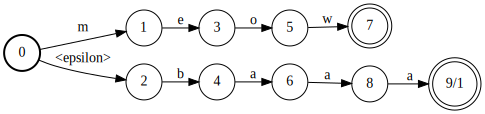

In [15]:
pynini.difference(animals, dog)  # Or: animals - dog

## Search operations

The `shortestpath` function produces an FST containing the $n$ "shortest" (i.e., lowest-weight) strings in the input FST. In the case that $n = 1$, this is simply the _Viterbi algorithm_. If $n > 1$ and `unique=True` (and assuming the FST is a determinizable, epsilon-free FSA), all paths are guaranteed to be unique.

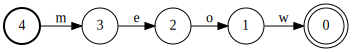

In [16]:
pynini.shortestpath(animals).rmepsilon()  # Makes this a bit easier to read, see below.

## Optimization operations

(The following is adapted from Pynini's documentation: see [here](http://www.opengrm.org/twiki/bin/view/GRM/PyniniOptimizeDoc) for more details.)

In _Anna Karenina_ Leo Tolstoy writes:

> All happy families are alike; each unhappy family is unhappy in its own way.

The same is true of WFSTs. Informally, _optimization_ refers to computing an equivalent machines with fewer states and/or arcs. More formally, a WFST is said to be _minimal_ if there is no _equivalent_ WFST that generates the same language or the same relation&mdash;with fewer states. The hard part, of course, is finding this WFST. And, as we will see, there are many ways an WFST can be suboptimal.

### Arc-sum mapping

WFSTs may have identically labeled _multi-arcs_, arcs with the same source state, destination state, input label, and output-label. _Arc-sum mapping_ merges such arcs (using &oplus; to combine their weights) making the WFST _multi-arc-free_.

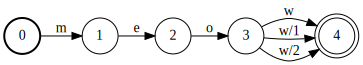

In [17]:
cat = pynini.acceptor("meow")
cat.add_arc(3, pynini.Arc(ord("w"), ord("w"), pynini.Weight("tropical", 1), 4))  # Adds a multi-arc.
cat.add_arc(3, pynini.Arc(ord("w"), ord("w"), pynini.Weight("tropical", 2), 4))  # Adds another one.

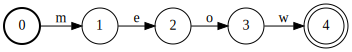

In [18]:
cat = pynini.statemap(cat, map_type="arc_sum")  # Constructive operation.
cat

### Epsilon-removal

WFST operations (including composition, concatenation, and union) introduce _epsilon-transitions_, arcs with epsilon input and output labels. _Epsilon-removal_ removes these transitions.

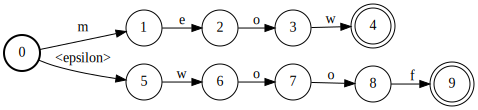

In [19]:
dog = pynini.acceptor("woof")
cat_or_dog = pynini.union(cat, dog)
cat_or_dog

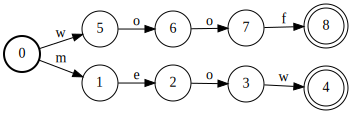

In [20]:
cat_or_dog.rmepsilon()

However, note that `rmepsilon` does not remove arcs with an epsilon on only one side, and in fact, there is no equivalent epsilon-free machine for many transducers.

### Determinization

A WFST is _deterministic_ if for each state, there is never more than one arc with a given label leaving that state. _Determinization_ makes an WFST deterministic. Two caveats are in order, however:

* This can actually increase the size of the WFST (exponentially even), but it is a prerequisite for the minimization, the final optimization step.
* Not all WFSTs are determinizable. Characterizing the class of determinizable WFSTs is complex, but in general, an WFST is not determinizable if it:
  - is a _non-functional_ transducer
  - has _weighted cycles_

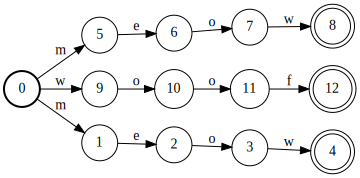

In [21]:
# Multiple "m" arcs leaving state 0.
cat_or_dog = pynini.union(cat, cat, dog).rmepsilon()
cat_or_dog

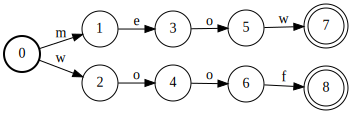

In [22]:
cat_or_dog = pynini.determinize(cat_or_dog)
cat_or_dog

### Minimization

As we said earlier, a WFST is _minimal_ if it has the minimum number of states possible for expressing its relation. _Minimization_ modifies a deterministic WFST's topology so that it becomes minimal.

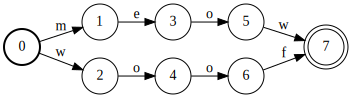

In [23]:
cat_or_dog.minimize()

### Optimization

The full procedure is as follows:

* Check if the WFST is (known to be) epsilon-free; if not, perform epsilon removal.
* Perform arc-sum mapping
* If the WFST is (known to be) an acyclic acceptor (a determinizable type of WFST) but not (known to be) deterministic, derminize it and minimize it
* If the WFST is not (known to be) an acceptor, determinize and minimize it _as if it were an (unweighted) acceptor_, and then arc-sum map.

The `optimize` method puts all these steps together.

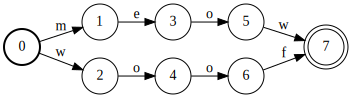

In [24]:
cat_or_dog = pynini.union(cat, cat, dog)
cat_or_dog.optimize()

One this is complete, we can assert the following about the WFST: 

* It is free of identically-labeled multi-arcs and epsilon arcs.
* If it was an acyclic acceptor, it is deterministic and minimal.

It is an open question exactly when `optimize` is beneficial, but a good rule of thumb is:

* apply epsilon-removal and/or optimization to unions and concatenations
* apply optimization to a cascade of compositions or intersections
* apply optimization to context-dependent rewrite rules
* apply optimization to FST before writing them to disk

A good way to measure the notional size of an FST is to count the number of states and arcs. However, there is no guarantee that optimize will reduce the size according to this metric.

In [25]:
def fst_size(f):
    """Computes the number of states and arcs in an FST."""
    return sum(1 + f.num_arcs(state) for state in f.states())


fst_size(cat_or_dog)

16